In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    res=np.linalg.lstsq(tx,y,rcond=-1)
    w=res[0]
    MSE=res[1]/(2*len(tx))
    return w, MSE

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [3]:
from helpers import *
from grid_search import *
from costs import *
from gradient_descent import *

def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    #Least squares
    w_ls, MSE_ls=least_squares(y,tx)
    
    #Grid search
    grid_w0, grid_w1 = generate_w(num_intervals=10)
    grid_losses = grid_search_(y, tx, grid_w0, grid_w1)
    loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
    w_gs=[w0_star, w1_star]
    MSE_gs=[loss_star]
    
    #GD
    max_iters = 50
    gamma = 0.7
    w_initial = np.array([0, 0])
    MSE_gd, w_gd = gradient_descent(y, tx, w_initial, max_iters, gamma)

    print ("Results obtained via least squares regression: w0={:.2f}, w1={:.2f}, MSE={:.2f}".format(w_ls[0],w_ls[1],MSE_ls[0]))
    print ("Results obtained via grid search: w0={:.2f}, w1={:.2f}, MSE={:.2f}".format(w_gs[0],w_gs[1],MSE_gs[0]))
    print ("Results obtained via gradient descent: w0={:.2f}, w1={:.2f}, MSE={:.2f}".format(w_gd[-1][0],w_gd[-1][1],MSE_gd[-1]))


Test it here

In [4]:
test_your_least_squares()

Results obtained via least squares regression: w0=73.29, w1=13.48, MSE=15.39
Results obtained via grid search: w0=66.67, w1=16.67, MSE=42.42
Results obtained via gradient descent: w0=73.29, w1=13.48, MSE=15.39


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [5]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [6]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    phi = np.zeros((len(x),degree+1))
    for ind, x_ in enumerate(x):
        for j in np.arange(degree+1):
            phi[ind,j]=pow(x_,j)
    return phi

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [7]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        phi=build_poly(x,degree)
        weights,MSE=least_squares(y, phi)
        rmse=np.sqrt(2*MSE[0])

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.2585827766773748
Processing 3th experiment, degree=7, rmse=0.24965870360907053
Processing 4th experiment, degree=12, rmse=0.24032507479311802


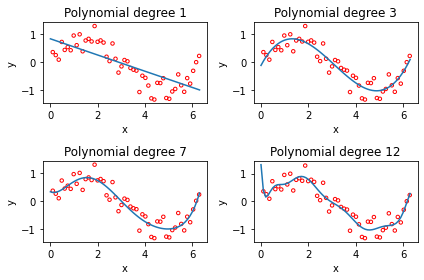

In [8]:
polynomial_regression()

RMSE decreases as we increase the degree of the polynomial. However, it doesn't mean that the fit gets better as we increase the degree, because of the fact that if the model is too rich, we also fit the noise in the date as well. The best model in my view is the one with degree=7

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [9]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    
    # get the number of datapoint dedicated to training
    Tr=round(ratio*x.shape[0])
    Te=round(x.shape[0]-Tr)
    
    # shuffle the two lists with same order
    temp = list(zip(x, y)) 
    np.random.shuffle(temp) 
    res1, res2 = zip(*temp)

    x_training=[res1[:Tr]][0]
    y_training=[res2[:Tr]][0]
    x_test=[res1[Tr:]][0]
    y_test=[res2[Tr:]][0]
    
    return x_training,y_training,x_test,y_test

Then, test your `split_data` function below.

In [10]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    x_training,y_training,x_test,y_test=split_data(x, y, ratio, seed)
    x_training=build_poly(x_training,degree)
    x_test=build_poly(x_test,degree)
    
    w_tr,mse_tr=least_squares(y_training, x_training)
    if not len(mse_tr):
        rmse_tr=0
    else:
        rmse_tr=np.sqrt(2*mse_tr[0])
    
    err=x_test@w_tr-y_test
    mse_te=1/(2*len(x_test))*np.sum(np.square(err))
    rmse_te=np.sqrt(2*mse_te)
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

In [11]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.065
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=2.202
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=10.218


# 3 Ridge Regression
Please fill in the function below.

In [15]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    lambda_=lambda_*(2*len(tx))
    w=np.dot(np.linalg.inv(np.dot(tx.T,tx)+lambda_*np.identity(tx.shape[1])),np.dot(tx.T,y))
    err=tx@w-y
    mse=1/(2*len(tx))*np.sum(np.square(err))
    return w, mse

In [16]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    
    x_training,y_training,x_test,y_test=split_data(x, y, ratio, seed)
    x_training=build_poly(x_training,degree)
    x_test=build_poly(x_test,degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        w_tr,mse_tr=ridge_regression(y_training, x_training, lambda_)
        rmse_tr.append(np.sqrt(2*mse_tr))
        err=x_test@w_tr-y_test
        mse_te=1/(2*len(x_test))*np.sum(np.square(err))
        rmse_te.append(np.sqrt(2*mse_te))
        
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

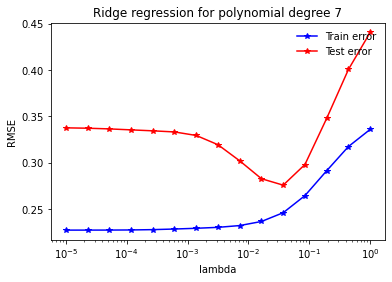

In [17]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)